# **Переобучение нейронных сетей и борьба с ним**

In [ ]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

# __________end of block__________

In [ ]:
# do not change the code in the block below
# __________start of block__________

def args_and_kwargs(*args, **kwargs):
    return args, kwargs

def parse_pytorch_model(model_str):
    def parse_layer(layer_str):
        layer_name, params = layer_str.split("(", 1)
        layer_info = {"type": layer_name.strip()}
        params_template = layer_str.replace(layer_name, "args_and_kwargs")

        param_dict = {}
        if len(params):
            args, kwargs = eval(params_template)
            if len(args) or len(kwargs):
                param_dict["args"] = args
                for name, value in kwargs.items():
                    param_dict[name] = value
        layer_info["parameters"] = param_dict
        return layer_info

    model_dict = {}
    lines = model_str.splitlines()
    model_name = lines[0].strip("()")
    model_dict["model_name"] = model_name
    model_dict["layers"] = []

    layer_regex = re.compile(r"\((\d+)\): (.+)")
    for line in lines[1:]:
        line = line.strip()
        match = layer_regex.match(line)
        if match:
            index, layer = match.groups()
            model_dict["layers"].append({"index": int(index), "layer": parse_layer(layer)})
    return model_dict

# __________end of block__________

In [ ]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Загрузите файл `hw_overfitting_data_dict.npy` (ссылка есть на странице с заданием), он понадобится для генерации посылок. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).


In [ ]:
!wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict -O hw_overfitting_data_dict.npy

--2025-11-01 11:48:00--  https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict [following]
--2025-11-01 11:48:01--  https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272446 (6.0M) [application/octet-stream]
Saving to: ‘hw_overfitting_data_dict.npy’

hw_overfitting_data 100%[===================>]   5.98M  --.-KB/s 

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

### Задача №1 (уже решённая): Создание и обучение модели (Separation)
Вы уже решали эту задачу ранее, так что сейчас просто воспроизведите своё решение. Оно понадобится вам в дальнейших шагах.
__Ваша первая задача всё та же: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__


In [ ]:
CUDA_DEVICE_ID = 0  # change if needed

In [ ]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 197kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.72MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.6MB/s]


Text(0.5, 1.0, 'Image label: 7')

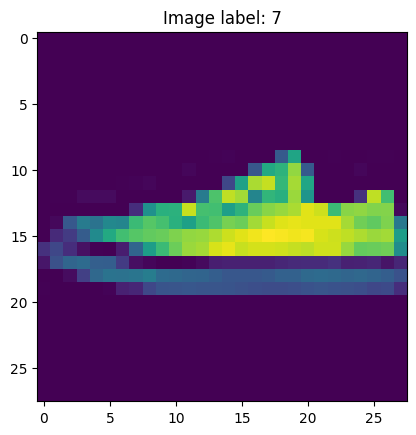

In [ ]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model_task_1`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [100]:
from torchsummary import summary
class CNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.convolution = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.Conv2d(6, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.linear = nn.Sequential(
            nn.Linear(16 * 7 * 7, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):

        x = x.reshape(-1, 1, 28, 28)
        x = self.convolution(x)
        x = x.reshape(-1, 16 * 7 * 7)
        x = self.linear(x)
        return x

model_task_1 = CNN()
model_task_1.to(device)
summary(model_task_1, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              60
         MaxPool2d-2            [-1, 6, 14, 14]               0
       BatchNorm2d-3            [-1, 6, 14, 14]              12
              ReLU-4            [-1, 6, 14, 14]               0
            Conv2d-5           [-1, 16, 14, 14]             880
         MaxPool2d-6             [-1, 16, 7, 7]               0
       BatchNorm2d-7             [-1, 16, 7, 7]              32
              ReLU-8             [-1, 16, 7, 7]               0
            Linear-9                   [-1, 64]          50,240
      BatchNorm1d-10                   [-1, 64]             128
             ReLU-11                   [-1, 64]               0
           Linear-12                   [-1, 10]             650
Total params: 52,002
Trainable params: 52,002
Non-trainable params: 0
---------------------------------

Не забудьте перенести модель на выбранный `device`!

Локальные тесты для проверки вашей модели доступны ниже:

In [101]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [102]:
import time

default_dtype = torch.float32

def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, device=device):
    """
    model: nn tp train
    train_loader, val_loader: data loaders
    loss_fn: loss function to minimize
    opt: optimizer to update NN weights using gradient descent
    n_epochs: number of epochs = number of full data iterations
    """
    train_loss = []
    val_loss = []
    val_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True)  # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)

            opt.zero_grad()
            loss.backward()

            opt.step()

            ep_train_loss.append(loss.item())

        model.train(False)  # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                # YOUR CODE HERE
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                preds = model(X_batch)
                loss = loss_fn(preds, y_batch)

                # compute predictions
                # YOUR CODE HERE
                ep_val_loss.append(loss.item())  # YOUR CODE HERE
                y_pred = preds.max(-1)[1]  # YOUR CODE HERE
                ep_val_accuracy.append((y_pred == y_batch).to(default_dtype).mean().item())  # YOUR CODE HERE

        # print the results for this epoch:
        print(f"Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s")

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy


loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_task_1.parameters(), lr=1e-3)

num_epochs = 3
train_loss, val_loss, val_acc = train_model(model_task_1, train_data_loader, test_data_loader, loss_fn, optim, num_epochs)


Epoch 1 of 3 took 15.003s
	  training loss: 0.420758
	validation loss: 0.353352
	validation accuracy: 0.869
Epoch 2 of 3 took 14.621s
	  training loss: 0.285724
	validation loss: 0.291103
	validation accuracy: 0.892
Epoch 3 of 3 took 14.558s
	  training loss: 0.250216
	validation loss: 0.277972
	validation accuracy: 0.896


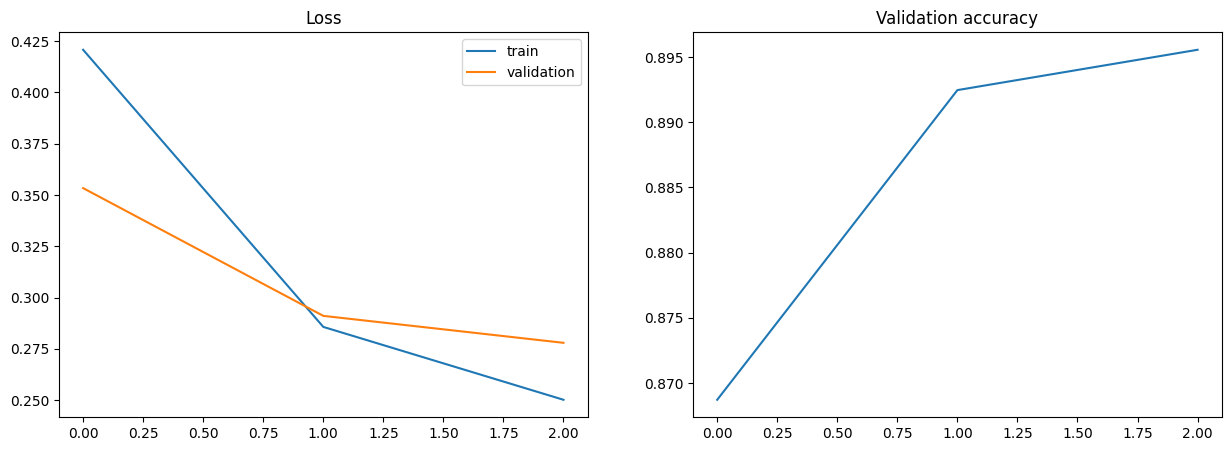

In [103]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title("Loss")
    axes[0].plot(train_loss, label="train")
    axes[0].plot(val_loss, label="validation")
    axes[0].legend()

    axes[1].set_title("Validation accuracy")
    axes[1].plot(val_accuracy)

plot_train_process(train_loss, val_loss, val_acc)

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [104]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.92478


In [105]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.8956


Проверка, что необходимые пороги пройдены:

In [106]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Test accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_1`.

In [107]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
    "model_task_1": parse_pytorch_model(str(model_task_1)),
}

with open("submission_dict_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_task_1.json`")
# __________end of block__________

File saved to `submission_dict_task_1.json`


### Задача №2: Переобучение (Initiation)
Продолжим работу с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Теперь ваша задача продемонстрировать переобучение модели на обучающей выборке. Достаточно показать, что точность классификации (не только функция потерь!) на тестовой выборке значительно отстает от обучающей.

Обращаем ваше внимание, в задаче №3 вам придется починить данную модель (минимизировать эффект переобучения) с помощью механизмов регуляризации, поэтому не переусердствуйте!

__Ваша вторая задача: реализовать используя пайплан обучения модели продемонстрировать переобучения модели на обучающей выборке.__

Код для обучения модели вы можете переиспользовать. Далее присутствует лишь несколько тестов, которые помогут вам проверить свое решение.

Обращаем внимание, вам необходимо использовать переменную `model_task_2` для хранение модели во второй задаче.

Не используйте `Dropout` и `BatchNorm` в этой задаче

In [108]:
from torchsummary import summary
class CNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.convolution = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU()
        )

        self.linear = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):

        x = x.reshape(-1, 1, 28, 28)
        x = self.convolution(x)
        x = x.reshape(-1, 64 * 7 * 7)
        x = self.linear(x)
        return x

model_task_2 = CNN()
model_task_2.to(device, torch.float32)
summary(model_task_2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
         MaxPool2d-5             [-1, 64, 7, 7]               0
              ReLU-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.43
Params size (MB): 1.61
Estimated Total Size (MB): 2.04
-------------------------------------------

Проверка архитектуры:

In [109]:
# do not change the code in the block below
# __________start of block__________
layers_task_2 = []
for element in parse_pytorch_model(str(model_task_2)).get("layers", []):
    layer_name = element["layer"]["type"]
    assert "dropout" not in layer_name.lower(), "Do not use Dropout in Task 2!"
    assert "batchnorm" not in layer_name.lower(), "Do not use BatchNorm in Task 2!"
    layers_task_2.append(layer_name)
# __________end of block__________

In [110]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_task_2.parameters(), lr=0.001)

num_epochs = 10
train_loss, val_loss, val_acc = train_model(model_task_2, train_data_loader, test_data_loader, loss_fn, optim, num_epochs)


Epoch 1 of 10 took 14.351s
	  training loss: 0.431642
	validation loss: 0.334375
	validation accuracy: 0.882
Epoch 2 of 10 took 14.219s
	  training loss: 0.279905
	validation loss: 0.279075
	validation accuracy: 0.894
Epoch 3 of 10 took 14.871s
	  training loss: 0.234608
	validation loss: 0.276795
	validation accuracy: 0.901
Epoch 4 of 10 took 15.344s
	  training loss: 0.201535
	validation loss: 0.250311
	validation accuracy: 0.909
Epoch 5 of 10 took 14.253s
	  training loss: 0.174483
	validation loss: 0.243231
	validation accuracy: 0.914
Epoch 6 of 10 took 13.957s
	  training loss: 0.150269
	validation loss: 0.245072
	validation accuracy: 0.919
Epoch 7 of 10 took 14.824s
	  training loss: 0.130178
	validation loss: 0.244287
	validation accuracy: 0.920
Epoch 8 of 10 took 14.004s
	  training loss: 0.109370
	validation loss: 0.253575
	validation accuracy: 0.921
Epoch 9 of 10 took 14.167s
	  training loss: 0.092730
	validation loss: 0.280157
	validation accuracy: 0.917
Epoch 10 of 10 took

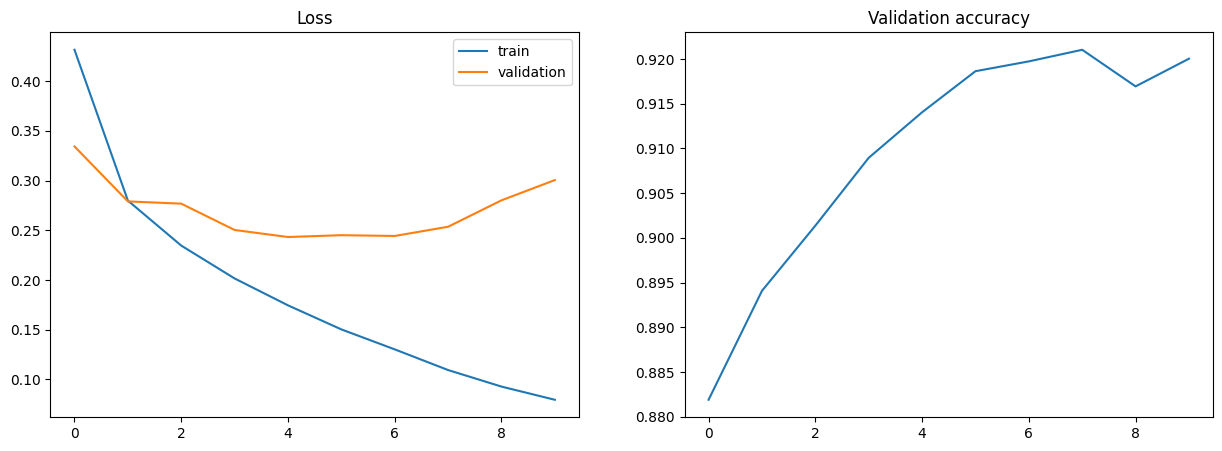

In [111]:
plot_train_process(train_loss, val_loss, val_acc)

Оценим качество классификации:

In [112]:
train_acc_task_2 = get_accuracy(model_task_2, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_2:3.5}")

Neural network accuracy on train set: 0.98255


In [113]:
test_acc_task_2 = get_accuracy(model_task_2, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_2:3.5}")

Neural network accuracy on test set: 0.92


Проверка, что переобучение присутствует:

In [114]:
assert train_acc_task_2 >= test_acc_task_2, "Train accuracy must be higher than task accuracy"
assert train_acc_task_2 >= 0.88, "Train accuracy must be higher than 0.88"
assert (
    train_acc_task_2 - test_acc_task_2 >= 0.04
), "Test accuracy should be at least 0.04 lower that train."

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_2`.

Также предполагается, что в переменной `submission_dict` уже содержатся результаты задачи №1. Если их там нет, загрузите их из сохраненного файла в переменную перед запуском следующей ячейки.

In [115]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_2": parse_pytorch_model(str(model_task_2)),
    }
)

with open("submission_dict_tasks_1_and_2.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_tasks_1_and_2.json`")
# __________end of block__________

File saved to `submission_dict_tasks_1_and_2.json`


### Задача №3: Исправление модели (Return)
Все так же работаем с [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Наконец, ваша задача исправить ~~ошибки прошлого~~ переобучение модели, построенной в задаче 2. Достаточно добиться расхождения между точностью классификации на обучающей и тестовой выборках не превышающего 0.015 (т.е. полутора процентов).

Обращаем ваше внимание, архитектура модели в задаче №3 не должна существенно отличаться от задачи №2! Вы можете использовать Batchnorm, Dropout, уменьшить размерность промежуточных представлений, обратиться к аугментации данных, но вы не можете использовать меньшее количество слоёв.

__Ваша третья и финальная задача: исправить модель и/или процесс обучения, дабы справиться с переобучением.__

Код для обучения модели вы можете переиспользовать. Далее присутствует лишь несколько тестов, которые помогут вам проверить свое решение.

Обращаем внимание, вам необходимо использовать переменную `model_task_3` для хранение модели во второй задаче.

Также код ниже будет обращаться к переменной `layers_task_2`, инициализируйте её, если она не определена.

In [116]:
# do not change the code in the block below
# __________start of block__________
assert (
    layers_task_2 is not None
), "Initializa layers_task_2 vairable which contains list of layers in task 2 model"
# __________end of block__________

In [140]:
from torchsummary import summary
class CNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.convolution = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5),
            nn.ReLU()
        )

        self.linear = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):

        x = x.reshape(-1, 1, 28, 28)
        x = self.convolution(x)
        x = x.reshape(-1, 64 * 7 * 7)
        x = self.linear(x)
        return x

model_task_3 = CNN()
model_task_3.to(device, torch.float32)
summary(model_task_3, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
       BatchNorm2d-3           [-1, 32, 14, 14]              64
           Dropout-4           [-1, 32, 14, 14]               0
              ReLU-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 64, 14, 14]          18,496
         MaxPool2d-7             [-1, 64, 7, 7]               0
       BatchNorm2d-8             [-1, 64, 7, 7]             128
           Dropout-9             [-1, 64, 7, 7]               0
             ReLU-10             [-1, 64, 7, 7]               0
           Linear-11                  [-1, 128]         401,536
      BatchNorm1d-12                  [-1, 128]             256
          Dropout-13                  [-1, 128]               0
             ReLU-14                  [

Проверка архитектуры:

In [141]:
# do not change the code in the block below
# __________start of block__________
layers_task_3 = []
for element in parse_pytorch_model(str(model_task_3)).get("layers", []):
    layer_name = element["layer"]["type"]
    layers_task_3.append(layer_name)


idx = 0
for model_3_layer in layers_task_3:
    model_2_layer = layers_task_2[idx]
    if "dropout" not in model_3_layer.lower() and "batchnorm" not in model_3_layer.lower():
        assert (
            model_3_layer == model_2_layer
        ), "Models in tasks 2 and 3 must share the architecture except for Dropout and BatchNorm!"
        idx += 1
# __________end of block__________

Оценим качество классификации:

In [142]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_task_3.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 1
train_loss, val_loss, val_acc = train_model(model_task_3, train_data_loader, test_data_loader, loss_fn, optim, num_epochs)


Epoch 1 of 1 took 16.435s
	  training loss: 0.547537
	validation loss: 0.357238
	validation accuracy: 0.868


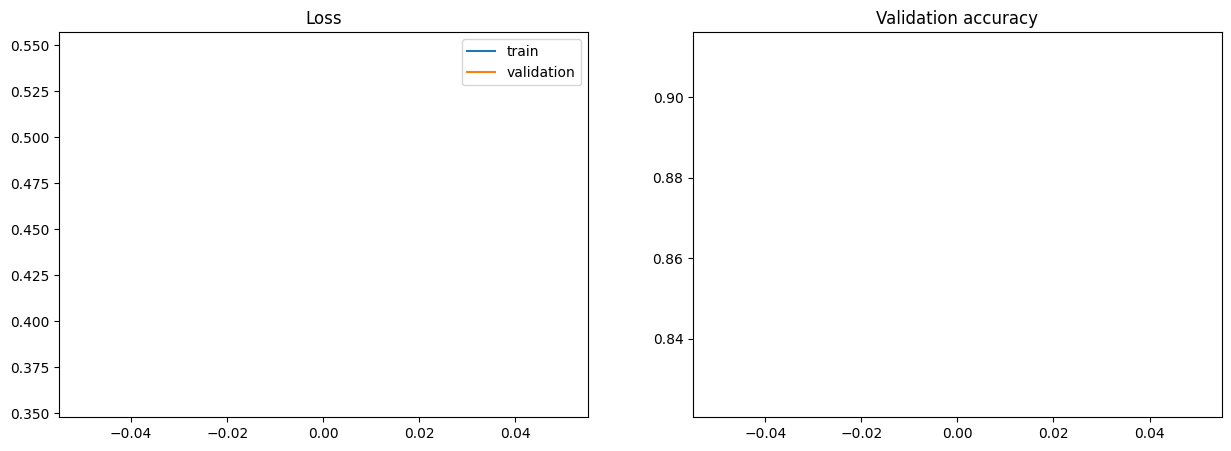

In [143]:
plot_train_process(train_loss, val_loss, val_acc)

In [144]:
train_acc_task_3 = get_accuracy(model_task_3, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_3:3.5}")

Neural network accuracy on train set: 0.88085


In [145]:
test_acc_task_3 = get_accuracy(model_task_3, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_3:3.5}")

Neural network accuracy on test set: 0.8683


Проверка, что переобучение присутствует:

In [146]:
assert train_acc_task_3 >= 0.88, "Train accuracy must be higher than 0.88"
assert train_acc_task_3 >= 0.865, "Test accuracy must be higher than 0.865"
assert (
    train_acc_task_3 - test_acc_task_3 <= 0.015
), "Test accuracy should not be lower that train more than by 0.015"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_3`.

Также предполагается, что в переменной `submission_dict` уже содержатся результаты задач №1 и №2. Если их там нет, загрузите их из сохраненных файлов перед запуском следующей ячейки.

In [147]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_3": parse_pytorch_model(str(model_task_3)),
    }
)

with open("submission_dict_final.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_final.json`")
# __________end of block__________

File saved to `submission_dict_final.json`


### Сдача задания
Сдайте сгенерированные файлы в соответствующие задачи в соревновании, а именно:
* `submission_dict_tasks_1_and_2.json` в задачу Initiation
* `submission_dict_final.json` в задачу Return.


`submission_dict_task_1.json` сдавать не нужно, он уже был сдан ранее.

На этом задание завершено. Поздравляем!